In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

In [3]:
load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\raw_output\\results\\jupyter_ver9copy\\models\\seq_len3_b1norm_noclip_3out_16-32-64-128.keras'
model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

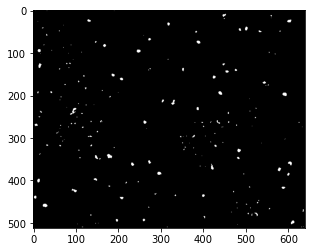

In [6]:
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\From erik\\HighMagDarkFieldLongerDOF'
im_stack = get_image_stack(
    outputs=[[0,1], [1,2]], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])

# plot_image_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,2]>0.5, cmap='gray')

In [7]:
positions = extract_positions(
    no_of_frames=100, 
    outputs=[[0,2], [2,4]],
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    model=model, 
    layer=2, 
    value_threshold=0.5,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])


In [8]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=10, threshold = 5, extrapolate=True)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=20)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0.0, list_of_plankton=list_of_plankton)

In [9]:
plot_and_save_track(no_of_frames=100,
                    plankton_track=plankton_track,
                    plankton_dont_track=plankton_dont_track,
                    folder_path=folder_path,
                    frame_im0=2,
                    save_images=True,
                    show_plankton_track = True,
                    show_plankton_dont_track = 0,
                    show_numbers_track = 0,
                    show_numbers_dont_track = 0,
                    show_numbers_specific_plankton = False,
                    show_specific_plankton = False,
                    specific_plankton = None,
                    color_plankton_track = 'b',
                    color_plankton_dont_track = 'r',
                    color_specific_plankton = 'w',
                    save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Oxhyris2\\track',
                    frame_name = 'track',
                    file_type = '.jpg')

In [10]:
Make_video(frame_im0=0,
           folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Oxhyris2\\track', 
           save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Oxhyris2\\Test_video0.5.avi', 
           fps=7, 
           no_of_frames=100)